In [17]:
#nettoyage variables
%reset

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read csv file
data = pd.read_csv('data/stat_acc_V3_cleared.csv', sep=';')


In [19]:
#fonction de nettoyage des variables
def prepa_data():
    #replacer le format date 'YYYYMMDD HH:MM' en format numeric 'YYYYMMDDHHMM'
    data['date'] = data['date'].str.replace(':','')
    data['date'] = data['date'].str.replace('-','')
    data['date'] = data['date'].str.replace(' ','')

    #convertir la colonne date en numeric
    data['date'] = pd.to_numeric(data['date'])

    new_data = data

    #supression colonne num_veh
    new_data = new_data.drop('num_veh', axis=1)

    #drop colonne ville
    new_data = new_data.drop('ville', axis=1)

    #drop colonne id_code_insee
    new_data = new_data.drop('id_code_insee', axis=1)

    #drop colonne Num_Acc
    new_data = new_data.drop('Num_Acc', axis=1)

    #drop colonne id_usa
    data = data.drop('id_usa', axis=1)



prepa_data()

In [20]:
# Identifier les attributs fortement corrélés

# Créer une matrice de corrélation
corr_matrix = new_data.corr().abs()

# Identifiez les paires d'attributs fortement corrélés
threshold = 0.8  # Définissez votre propre seuil de corrélation
highly_correlated_pairs = []

# Parcourir la matrice de corrélation
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            highly_correlated_pairs.append(pair)

#verifier les paires d'attributs fortement corrélés
# print(highly_correlated_pairs)

# Afficher les paires d'attributs fortement corrélés
for pair in highly_correlated_pairs:
    print("Attribut 1:", pair[0])
    print("Attribut 2:", pair[1])

    #suppression d'une des deux colonnes fortement corrélées (ici on supprime la colonne 'an_nais' jugée moins pertinente)
    new_data = new_data.drop(pair[0], axis=1)

    print()

#obtenir le nombre de colonnes avant et après suppression
print("Nombre de colonnes avant suppression: ", len(data.columns))
print("Nombre de colonnes après suppression: ", len(new_data.columns))

#print pourcentage de réduction
print("Pourcentage de réduction: ", round((len(data.columns) - len(new_data.columns)) / len(data.columns) * 100, 2), "%")

Attribut 1: an_nais
Attribut 2: age

Nombre de colonnes avant suppression:  20
Nombre de colonnes après suppression:  16
Pourcentage de réduction:  20.0 %


### Clustering avec sklearn 

4    32418
0    24409
3    16053
1      502
2      258
Name: cluster_labels, dtype: int64


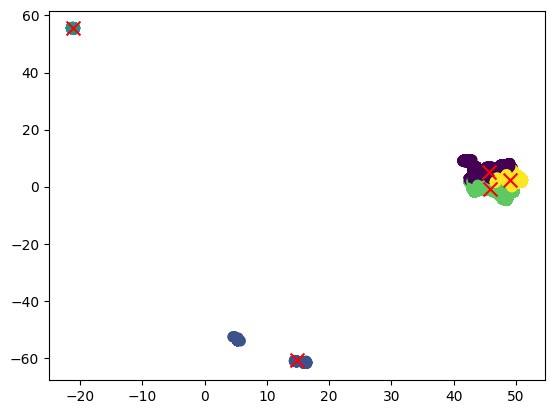

In [21]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
coordinates = data[['latitude', 'longitude']]
# for make cluster variable
# Plus le n augmente plus on gagne en précision sur latitude et longitude en séparant des régions 
n = 5 # 5 semble adéquat pour avoir DOM TOM + séparation nord sud centre France
kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(coordinates)
labels = kmeans.labels_
data['cluster_labels'] = labels # get label from dataframe
print(data['cluster_labels'].value_counts())

# Centroide 
centroids = kmeans.cluster_centers_

# graphiques de visualisation des clusters, avec les attributs latitude et longitude + centroide
plt.scatter(data['latitude'], data['longitude'], c=data['cluster_labels'], s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.show()



### Clustering en scratch avec Haversine

0.0    33321
2.0    16626
3.0    13683
1.0    10010
Name: cluster_labels, dtype: int64


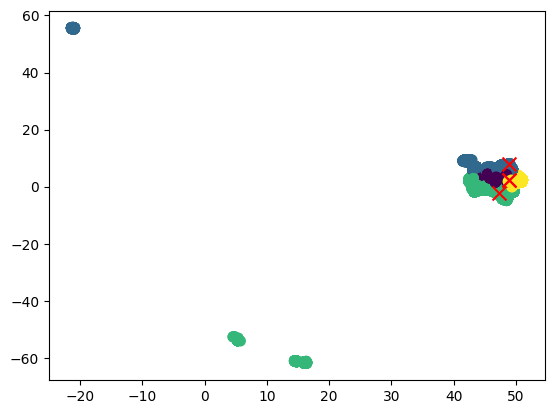

In [36]:
# Haversine calculer distance between two points on earth
# https://stackoverflow.com/questions/24762435/clustering-geo-location-coordinates-lat-long-pairs-using-kmeans-algorithm-with
# should have better result than with sklearn bc it's not euclidian distance
import math
import numpy as np
# https://gist.github.com/rochacbruno/2883505
def distHaversine(lat1, lon1, lat2, lon2):
    radius = 6371  # Rayon de la Terre en kilomètres
    dlat = math.radians(lat2 - lat1)    # distance btw 2 pts en radians
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

coordinates = data[['latitude', 'longitude']].values
n_clusters = 4
np.random.seed(0)
centroids = coordinates[np.random.choice(range(len(coordinates)), size=n_clusters, replace=False)]

# clustering avec utilisant la distance Haversine
labels = np.zeros(len(coordinates))

for i, point in enumerate(coordinates):
    min_distance = float('inf') # dist min par rapport au point infini
    # pour tt centroid
    for j, centroid in enumerate(centroids):
        dist = distHaversine(point[0], point[1], centroid[0], centroid[1]) # dist btw point and centroid
        if dist < min_distance:
            min_distance = dist 
            labels[i] = j  # indice centroïde --> label cluster pour le point de données

data['cluster_labels'] = labels
print(data['cluster_labels'].value_counts()) # nb point par cluster
# graphiques de visualisation des clusters, avec les attributs latitude et longitude + centroide
plt.scatter(data['latitude'], data['longitude'], c=data['cluster_labels'], s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.show()